<div style="display: flex; background-color: RGB(245, 203, 167);" >
<h1 style="margin: auto; padding: 30px; ">P12 - Analyse des faux billets</h1>
    </div>

<h3 style="text-align:center;">Auteur : Julien SERE | Date : 2025-3-6</h3>

## Importation des librairies

In [20]:
import math
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, confusion_matrix, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import normal_ad, kstest_fit, het_breuschpagan, het_white

## Importation du df

In [21]:
file_path = "C://Users//julie//Downloads//OC Formation//P12//billets.csv"
try:
    billets = pd.read_csv(file_path, sep =';')
    print("Données chargées avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement des données : {e}")

Données chargées avec succès.


## Analyse exploratoire des fichiers

In [22]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [23]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [24]:
billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

37 valeurs manquantes pour margin_low

### Traitement des valeurs manquantes par régression linéaire

#### Visualisation des courbes de régression

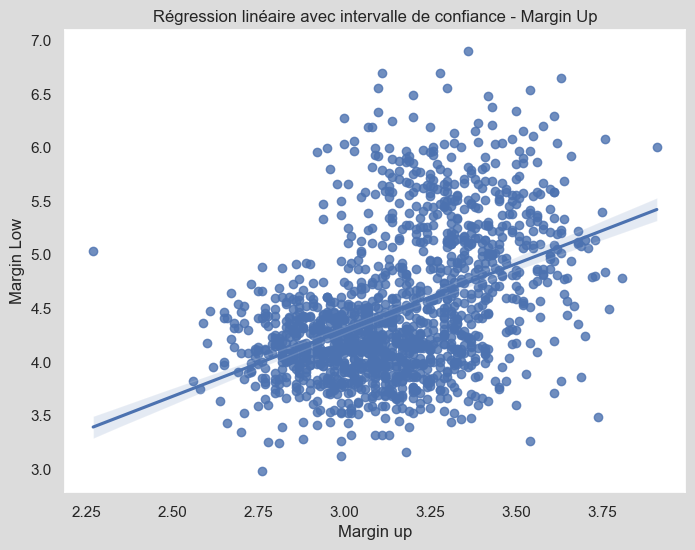

In [25]:
# Tracé du regplot
plt.figure(figsize=(8, 6))
sns.regplot(x='margin_up', y='margin_low', data=billets, ci=95)  #pour une zone d'incertitude à 95%
plt.xlabel("Margin up")
plt.ylabel("Margin Low")
plt.title("Régression linéaire avec intervalle de confiance - Margin Up")
plt.show()

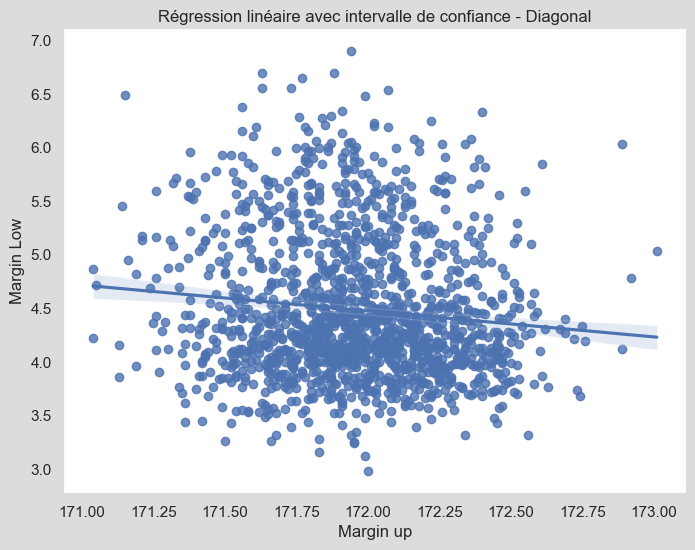

In [26]:
# Tracé du regplot
plt.figure(figsize=(8, 6))
sns.regplot(x='diagonal', y='margin_low', data=billets, ci=95)  #pour une zone d'incertitude à 95%
plt.xlabel("Margin up")
plt.ylabel("Margin Low")
plt.title("Régression linéaire avec intervalle de confiance - Diagonal")
plt.show()

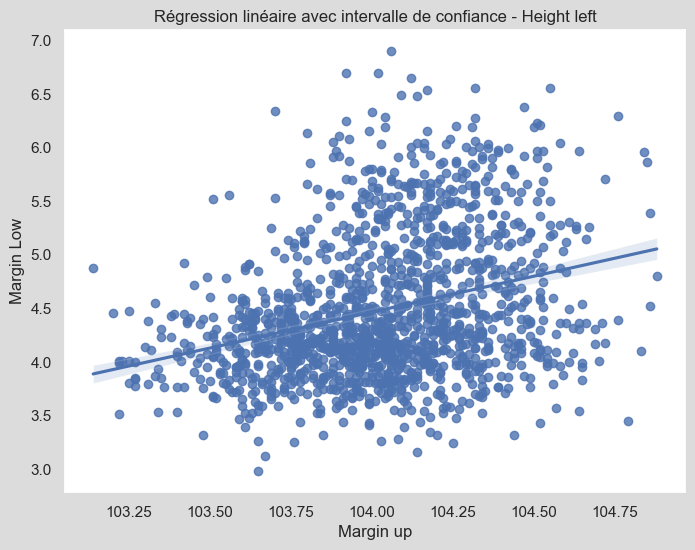

In [27]:
# Tracé du regplot
plt.figure(figsize=(8, 6))
sns.regplot(x='height_left', y='margin_low', data=billets, ci=95)  #pour une zone d'incertitude à 95%
plt.xlabel("Margin up")
plt.ylabel("Margin Low")
plt.title("Régression linéaire avec intervalle de confiance - Height left")
plt.show()

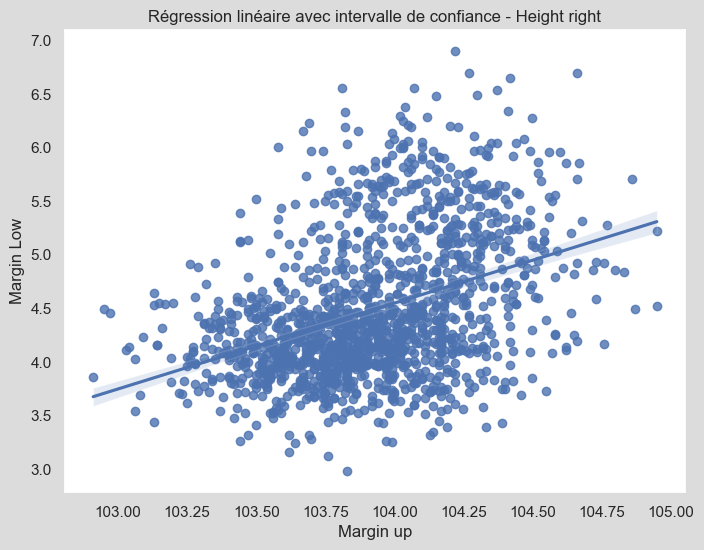

In [28]:
# Tracé du regplot
plt.figure(figsize=(8, 6))
sns.regplot(x='height_right', y='margin_low', data=billets, ci=95)  #pour une zone d'incertitude à 95%
plt.xlabel("Margin up")
plt.ylabel("Margin Low")
plt.title("Régression linéaire avec intervalle de confiance - Height right")
plt.show()

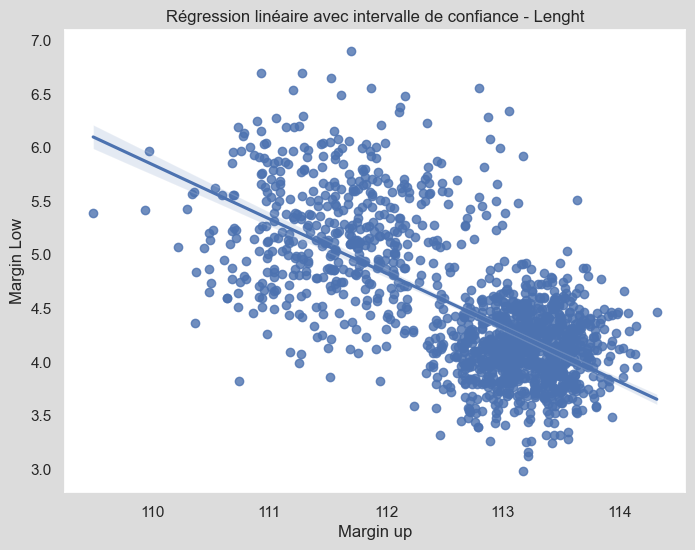

In [29]:
# Tracé du regplot
plt.figure(figsize=(8, 6))
sns.regplot(x='length', y="margin_low", data=billets, ci=95)  #pour une zone d'incertitude à 95%
plt.xlabel("Margin up")
plt.ylabel("Margin Low")
plt.title("Régression linéaire avec intervalle de confiance - Lenght")
plt.show()

#### Matrice de corrélation

La matrice de corrélation est d'abord exposée avec sa carte de fréquentation pour mettre en évidence les relations qui pourraient exister entre variables.

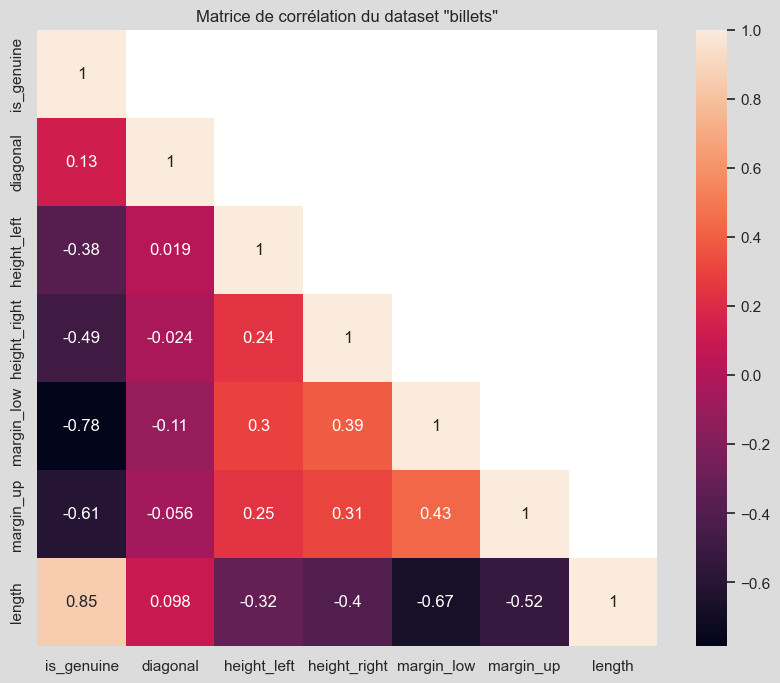

In [30]:
# masque permettant d'obtenir le triangle inferieur de la matrice
maskLowerTriangle = ~np.tril(np.ones(billets.corr().shape)).astype(bool) 

# création de la figure
plt.figure(figsize=(10, 8))
plt.title('Matrice de corrélation du dataset "billets"') 
sns.heatmap(billets.corr(), mask=maskLowerTriangle, annot=True) # carte de fréquentation.
plt.savefig("matrix_corr.png")
plt.show()


La variable lenght est la plus prédictive pour la véracité des billets, mais également la plus corrélée avec la variable margin_low

On applique et on teste notre modèle de régression linéaire multiple

### Régression Linéaire Simple

In [31]:
#Suppression des valeurs manquantes pour notre régression
billets_trim = billets.dropna(subset=['margin_low'])

Toutes les variables sont significatives (p-values inferieures a 5%).
La probabilite de la F-statistic est tres proche de zero, ce qui indique que notre modele est significatif (i.e. on peut rejeter l'hypothese nulle H0 que tous les coefficients sont egaux a zero puisque la probabilite de la F-statistic est inferieure au seuil alpha = 5%).
Le R2 et le R2 ajuste sont faibles (< 0.5), ce qui indique cependant une qualite de prevision mediocre.
Le Cond.No. indique un probleme de colinearite potentiel.

#### Execution du modèle de régression linéaire simple

In [32]:
# perform linear simple regression to complete margin_low column
y_reglin = billets_trim['margin_low']
x_reglin = billets_trim['length']
x_reglin = sm.add_constant(x_reglin, prepend=True, has_constant='skip')
reg_simple_reglin = sm.OLS(endog=y_reglin, exog=x_reglin).fit()
print(reg_simple_reglin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1169.
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          8.98e-189
Time:                        16:19:37   Log-Likelihood:                -1045.8
No. Observations:                1463   AIC:                             2096.
Df Residuals:                    1461   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.5960      1.670     36.881      0.0

In [33]:
# calculate Variance Inflation Factor each variable
vif_reglin = pd.DataFrame()
variables_reglin = reg_simple_reglin.model.exog
vif_reglin["variable"] = ['length']
vif_reglin["vi_factor"] = [variance_inflation_factor(variables_reglin, i) for i in np.arange(1, variables_reglin.shape[1])]
vif_reglin

,variable,vi_factor
0,length,1.0


Les VIFs sont inferieurs a 10, on peut donc exclure un probleme de multi-colinearite des variables.

In [34]:
billets_trim_reg = billets_trim.copy()
billets_trim_reg['margin_low_reglin'] = reg_simple_reglin.predict()
billets_trim_reg['residus_reglin'] = reg_simple_reglin.resid
billets_trim_reg.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_reglin,residus_reglin
0,True,171.81,104.86,104.95,4.52,2.89,112.83,4.407281,0.112719
1,True,171.46,103.36,103.66,3.77,2.99,113.09,4.275498,-0.505498
2,True,172.69,104.48,103.50,4.40,2.94,113.16,4.240018,0.159982
3,True,171.36,103.91,103.94,3.62,3.01,113.51,4.062618,-0.442618
4,True,171.73,104.28,103.46,4.04,3.48,112.54,4.554270,-0.514270


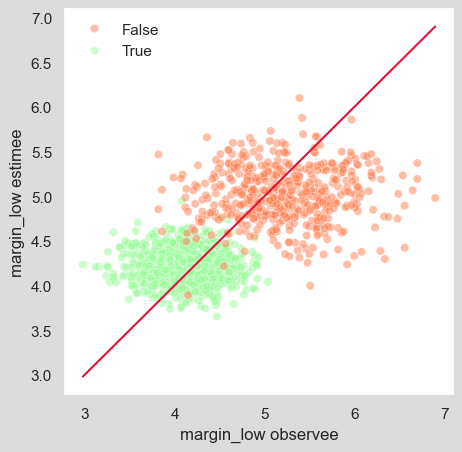

In [35]:
# plot adjusted values against observed values
sns.set(rc={'figure.figsize':(5,5),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
X_plot = [billets_trim_reg['margin_low'].min(), billets_trim_reg['margin_low'].max()]

ax = sns.scatterplot(x="margin_low", y="margin_low_reglin", data=billets_trim_reg, hue='is_genuine', alpha=0.5,
                     palette=['coral','palegreen'])
ax.set(xlabel='margin_low observee', ylabel='margin_low estimee')
plt.plot(X_plot, X_plot, color='crimson')
plt.legend(title='', frameon=False)
plt.savefig('margin_low_e_reglin.png')
plt.show()

Les résidus doivent avoir à peu près la même valeur moyenne pour les différentes valeurs de y prédites (fitted values).

On peut vérifier que cette condition est respectée par une 1) représentation graphique ou 2) par un test statistique (test de Rainbow).

#### Analyse des résidus

In [36]:
# Homoscedascticité des résidus Breusch-Pagan test
lm_bp, lm_pval_bp, f_val_bp, f_pval_bp = het_breuschpagan(reg_simple_reglin.resid, variables_reglin)
print('Lagrange multiplier statistic:', lm_bp)
print('p-value Lagrange multiplier statistic:', lm_pval_bp)

Lagrange multiplier statistic: 60.90273725885965
p-value Lagrange multiplier statistic: 5.996540571048788e-15


p-value inferieure à 5%, on rejette l'hypothese H0 du test de Breusch-Pagan => heteroscedasticite des residus.

Nombre d'observations: 1463
Premier quartile: -0.33337551470580684
Troisieme quartile: 0.2876560777359125


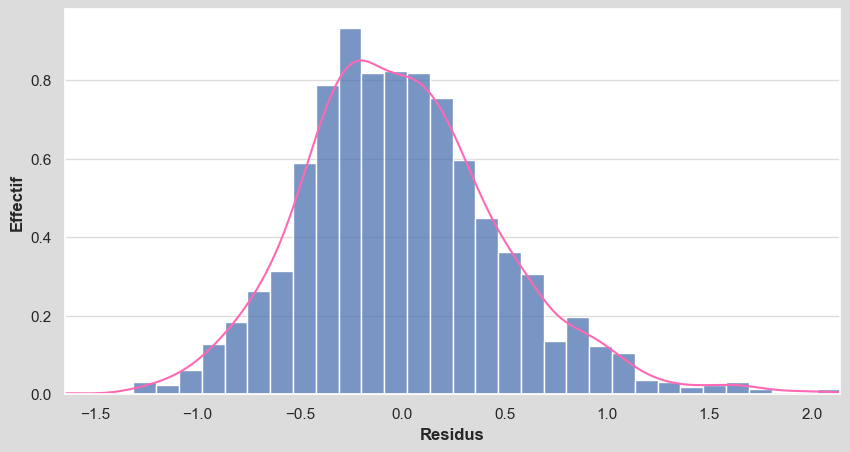

In [37]:
n = billets_trim_reg.shape[0]
print("Nombre d'observations:", n)

# calculate first quartile
Q1 = np.percentile(billets_trim_reg['residus_reglin'], 25)
print("Premier quartile:", Q1)

# calculate third quartile
Q3 = np.percentile(billets_trim_reg['residus_reglin'], 75)
print("Troisieme quartile:", Q3)

# calculate interquartile range
IQ = Q3 - Q1

# calculate bin width for histogram (Freedman-Diaconis rule)
bin_width = 2*((IQ)/np.cbrt(n))

# calculate number of bins for histogram
maxi = billets_trim_reg['residus_reglin'].max()
mini = billets_trim_reg['residus_reglin'].min()
nb_bins = ((maxi - mini) / bin_width).astype(int)

sns.set(rc={'figure.figsize':(10, 5), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph3b = sns.histplot(billets_trim_reg['residus_reglin'], bins=nb_bins, kde=False, stat='density')
sns.kdeplot(data=billets_trim_reg, x='residus_reglin', color='hotpink')
plt.xlim([mini, maxi])
plt.xlabel('Residus', fontweight='bold', fontsize='12')
plt.ylabel('Effectif', fontweight='bold', fontsize='12')
plt.grid(axis='y', color='gainsboro')
plt.savefig("histplot_kde_reglin.png", bbox_inches='tight')

On teste la normalité

#### Normalité des résidus

In [38]:
st.shapiro(reg_simple_reglin.resid)

ShapiroResult(statistic=0.9824796531420286, pvalue=2.394267255143311e-12)

La p-value est inferieure a 5%, donc on rejette H0, les residus ne sont pas normaux, mais leur observation, le fait que leur moyenne soit tres proche de zero et que l'echantillon soit de taille suffisante (superieure a 30) permettent de dire que les resultats obtenus par le modele lineaire ne sont pas absurdes.

In [39]:
# Lilliefors (Kolmogorov-Smirnov) normality test for mu and sigma unknown
stat_reglin, p_reglin = kstest_fit(billets_trim_reg['residus_reglin'], dist='norm', pvalmethod='table')
print("Kolmogorov-Smirnov statistic:", stat_reglin)
print("p-value:", p_reglin)

Kolmogorov-Smirnov statistic: 0.03896939471192562
p-value: 0.0009999999999998899


Aucun des tests effectues ne permet de conclure a la normalite des residus de la regression lineaire simple.

On teste une régression multiple.

### Regression lineaire multiple 

#### Selection des features 

Nous choisission des features les plus corrélés avec notre variable cible (margin_low)

In [40]:
# perform linear multiple regression to complete margin_low column
y_reglin_multi = billets_trim['margin_low']
x_reglin_multi = billets_trim[['height_right', 'margin_up', 'length']]
x_reglin_multi_const = sm.add_constant(x_reglin_multi, prepend=True, has_constant='skip')
reg_multi_reglin = sm.OLS(endog=y_reglin_multi, exog=x_reglin_multi_const).fit()
print(reg_multi_reglin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     429.7
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          5.37e-200
Time:                        16:19:38   Log-Likelihood:                -1012.8
No. Observations:                1463   AIC:                             2034.
Df Residuals:                    1459   BIC:                             2055.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.1826      5.443      4.259   

#### Colinéarité 

In [41]:
# calculate Variance Inflation Factor each variable
vif_reglin_multi = pd.DataFrame()
variables_reglin = reg_multi_reglin.model.exog
vif_reglin_multi["variable"] = ['height_right', 'margin_up', 'length']
vif_reglin_multi["vi_factor"] = [variance_inflation_factor(variables_reglin, i) for i in np.arange(1, variables_reglin.shape[1])]
vif_reglin_multi

,variable,vi_factor
0,height_right,1.213794
1,margin_up,1.394010
2,length,1.509435


Toutes les variables sont bien significatives

In [42]:
#Test de Rainbow
from statsmodels.stats.diagnostic import linear_rainbow

Ftest, pval = linear_rainbow(reg_multi_reglin)

print(pval)

1.4945568650014046e-07


Cela confirme que l'on peut rejeter l'hypothèse nulle du test de Rainbow, ce qui suggère qu'il y a effectivement des non-linéarités dans notre modèle de régression.

En d'autres termes, cela signifie que notre modèle linéaire ne décrit probablement pas bien la relation entre les variables. 

On ajoute des termes quadratiques à notre régression multiple, on peut tester également par un logarithme pour voir les effets.

#### Transformation quadratique

In [43]:
from sklearn.preprocessing import PolynomialFeatures

# **Régression polynomiale** (si besoin de termes quadratiques)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(x_reglin_multi)
X_poly = sm.add_constant(X_poly)

# Régression polynomiale
model_poly = sm.OLS(y_reglin_multi, X_poly).fit()
print(model_poly.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     143.3
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          2.44e-193
Time:                        16:19:38   Log-Likelihood:                -1011.3
No. Observations:                1463   AIC:                             2043.
Df Residuals:                    1453   BIC:                             2095.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -675.8699   1640.493     -0.412      0.6

Le modèle quadratique : 
R2 de 0.470 
🔸 Légère amélioration par rapport au modèle linéaire simple (0.445)


In [44]:
# Appliquer le logarithme sur x_reglin_multi
X_log = np.log(x_reglin_multi)
X_log = sm.add_constant(X_log)

# Ajustement du modèle de régression logarithmique
model_log = sm.OLS(y_reglin_multi, X_log).fit()

# Résumé du modèle
print(model_log.summary())


                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     429.5
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          6.29e-200
Time:                        16:19:38   Log-Likelihood:                -1013.0
No. Observations:                1463   AIC:                             2034.
Df Residuals:                    1459   BIC:                             2055.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           97.6548     25.292      3.861   

Significativité des variables : Toutes les variables (height_right, margin_up, et length) ont des p-values très faibles (inférieures à 0.05), ce qui indique que chacune des variables est significativement liée à la variable dépendante (margin_low).
Multicolinéarité : Le conditionnement du modèle est plus raisonnable (Cond. No. = 1.19e+03), ce qui suggère qu'il y a moins de problème de multicolinéarité que dans le modèle quadratique.

In [45]:
billets_trim_reg_quad = billets_trim.copy()
billets_trim_reg_quad['margin_low_reglin'] = model_log.predict()
billets_trim_reg_quad['residus_reglin'] = model_log.resid
billets_trim_reg_quad.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_reglin,residus_reglin
0,True,171.81,104.86,104.95,4.52,2.89,112.83,4.626384,-0.106384
1,True,171.46,103.36,103.66,3.77,2.99,113.09,4.191872,-0.421872
2,True,172.69,104.48,103.50,4.40,2.94,113.16,4.103245,0.296755
3,True,171.36,103.91,103.94,3.62,3.01,113.51,4.096754,-0.476754
4,True,171.73,104.28,103.46,4.04,3.48,112.54,4.503408,-0.463408


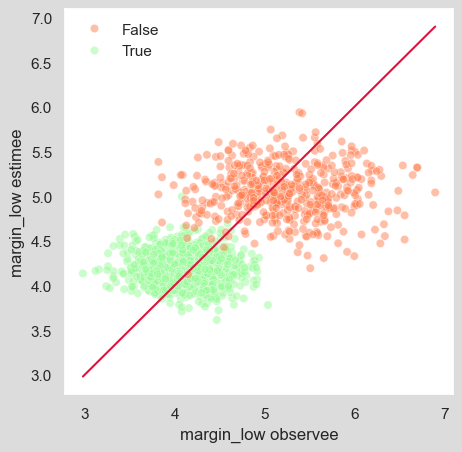

In [46]:
# plot adjusted values against observed values
sns.set(rc={'figure.figsize':(5,5),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
X_plot = [billets_trim_reg_quad['margin_low'].min(), billets_trim_reg_quad['margin_low'].max()]

ax = sns.scatterplot(x="margin_low", y="margin_low_reglin", data=billets_trim_reg_quad, hue='is_genuine', alpha=0.5,
                     palette=['coral','palegreen'])
ax.set(xlabel='margin_low observee', ylabel='margin_low estimee')
plt.plot(X_plot, X_plot, color='crimson')
plt.legend(title='', frameon=False)
plt.savefig('margin_low_e_reglin.png')
plt.show()

#### Analyse des résidus

In [47]:
# Homoscedascticité des résidus Breusch-Pagan test
variables_reglin_log = model_log.model.exog
# Ajouter la constante
variables_reglin_log = sm.add_constant(variables_reglin_log)

lm_bp, lm_pval_bp, f_val_bp, f_pval_bp = het_breuschpagan(model_log.resid, variables_reglin_log)
print('Lagrange multiplier statistic:', lm_bp)
print('p-value Lagrange multiplier statistic:', lm_pval_bp)

Lagrange multiplier statistic: 73.34647306046868
p-value Lagrange multiplier statistic: 8.19313217593296e-16


p-value inferieure à 5%, on rejette l'hypothese H0 du test de Breusch-Pagan => heteroscedasticite des residus.

#### Normalité des résidus

In [48]:
st.shapiro(model_log.resid)

ShapiroResult(statistic=0.9841951190768978, pvalue=1.4393332452378636e-11)

Aucun des tests effectues ne permet de conclure a la normalite des residus de la regression lineaire simple.

Les résidus ne suivent pas une distribution normale. Le modèle n'est pas optimal pour remplacer des valeurs manquantes, la décision optimale serait de supprimer les observations contenant des valeurs manquantes, mais pour notre projet, nous préférons les garder.

Après avoir optimisé notre modèle de regression linéaire, il est temps de remplacer les valeurs manquantes par notre modèle.

### Validation croisée

In [49]:
from sklearn.model_selection import KFold
import statsmodels.api as sm
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_index, test_index in kf.split(x_reglin_multi):
    X_train, X_test = x_reglin_multi.iloc[train_index], x_reglin_multi.iloc[test_index]
    y_train, y_test = y_reglin_multi.iloc[train_index], y_reglin_multi.iloc[test_index]

    # Ajout d'une constante
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Entraînement du modèle
    model = sm.OLS(y_train, X_train).fit()
    
    # Prédiction
    y_pred = model.predict(X_test)

    # Calcul du R²
    r2 = model.rsquared
    scores.append(r2)

# Résultats
print("Scores R² pour chaque fold :", scores)
print("Moyenne des scores R² :", np.mean(scores))
print("Écart-type des scores R² :", np.std(scores))


Scores R² pour chaque fold : [0.4549319281666969, 0.49318759716494176, 0.4695838639558565, 0.46636035832222056, 0.4633197537973115]
Moyenne des scores R² : 0.4694767002814054
Écart-type des scores R² : 0.012817083039117674


On a un R2 entre 0.45 et 0.49 : Le modèle explique environ 46.9% de la variance des données de test. Ce n'est pas exceptionnel mais c'est loin d'être mauvais.
Écart-type faible : Les performances sont cohérentes, donc le modèle est stable et ne varie pas beaucoup selon les folds.

## Remplacement des valeurs manquantes dans le DataFrame original

In [50]:
# Étape 3 : Imputer les valeurs manquantes dans 'margin_low'
# Créer une copie de la colonne margin_low pour éviter de la modifier directement
billets_with_const = billets[['height_right', 'margin_up', 'length']].copy()

# Appliquer la transformation logarithmique à billets_with_const
billets_with_const_log = np.log(billets_with_const)

# Ajouter une constante à billets_with_const_log
X_log_with_const = sm.add_constant(billets_with_const_log, has_constant='add')

# Prédictions des valeurs manquantes de 'margin_low' avec le modèle logarithmique
billets.loc[billets['margin_low'].isna(), 'margin_low'] = model_log.predict(X_log_with_const)[billets['margin_low'].isna()]
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [51]:
# re-check for duplicates
billets_final = billets.copy()

In [52]:
billets_final.to_csv('billets_final.csv', index=False, encoding='latin_1')


## Test des algorithmes

### Imports des modules

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, davies_bouldin_score, confusion_matrix, accuracy_score

### Séparation des données

In [54]:
# Séparation des données
X = billets_final.drop(columns=["is_genuine"])
y = billets_final["is_genuine"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Normalisation des données

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Execution des algorithmes de prédiction

### K-Means

Avant d'executer K-Means, il nous faut choisir le nombre de clusters. Même si il nous semble évident (2 pour la véracité ou non des billets), l'indice du coude peut nous permettre d'y voir plus clair.

#### Indice du coude

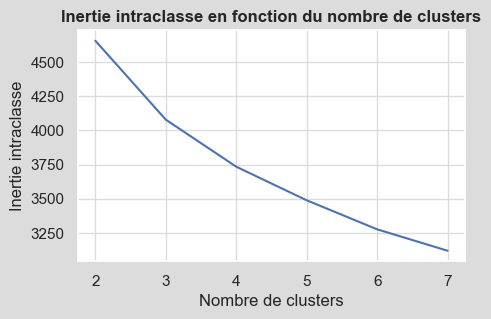

In [56]:
#Indice du coude
# test for number of clusters between 2 and number of columns in data (=11)
k_list = range(2, billets_final.shape[1]+1)

# create data for within-cluster sum of squares for K-means clusters between 2 and 11
wcss = []

for i in k_list :
    kmeans_wcss = KMeans(n_clusters=i, init='k-means++', copy_x=True, algorithm='elkan', n_init=30, max_iter=300,
                         verbose=0, random_state=42, tol=0.00001)
    kmeans_wcss.fit(X_train_scaled)
    wcss.append(kmeans_wcss.inertia_)

# plot wcss curve
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.set_ylabel("Inertie intraclasse")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Inertie intraclasse en fonction du nombre de clusters", fontsize=12, fontweight='bold')
ax = plt.plot(k_list, wcss)
plt.xticks(np.arange(min(k_list), max(k_list)+1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.show()

Coude distinctif pour 2 ou 3 clusters

#### Silhouette score

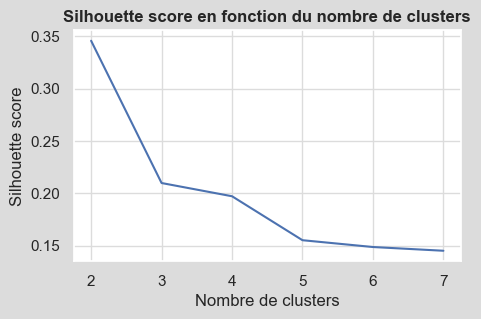

In [57]:
#Silhouette score
# calculate score for number of K-means clusters between 2 and 11
silhouette = []

for j in k_list :
    kmeans_silh = KMeans(n_clusters=j, init='k-means++', copy_x=True, algorithm='elkan', n_init=30, max_iter=300,
                         verbose=0, random_state=42, tol=0.00001)
    kmeans_silh.fit(X_train_scaled)
    silh = silhouette_score(X_train_scaled, kmeans_silh.labels_)
    silhouette.append(silh)
    
# plot silhouette score curve
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.set_ylabel("Silhouette score")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Silhouette score en fonction du nombre de clusters", fontsize=12, fontweight='bold')
ax = plt.plot(k_list, silhouette)
plt.xticks(np.arange(min(k_list), max(k_list)+1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.show()

Score maximal pour 2 et 3 clusters

#### Indice de Davies Bouldin

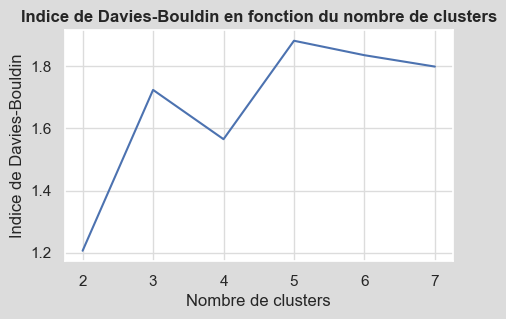

In [58]:
#Indice de Davies Bouldin
# calculate score for number of K-means clusters between 2 and 11
dav_bould = []


for h in k_list :
    kmeans_db = KMeans(n_clusters=h, init='k-means++', copy_x=True, algorithm='elkan', n_init=30, max_iter=300, verbose=0,
                       random_state=42, tol=0.00001)
    kmeans_db.fit(X_train_scaled)
    d_b = davies_bouldin_score(X_train_scaled, kmeans_db.labels_)
    dav_bould.append(d_b)

# plot Davies-Bouldin score curve
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.set_ylabel("Indice de Davies-Bouldin")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Indice de Davies-Bouldin en fonction du nombre de clusters", fontsize=12, fontweight='bold')
ax = plt.plot(k_list, dav_bould)
plt.xticks(np.arange(min(k_list), max(k_list)+1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.show()

Score optimal pour 2 clusters

#### Execution du k-means

In [59]:
import os
# Éviter la fuite mémoire sous Windows
os.environ["OMP_NUM_THREADS"] = "5"

# Standardisation sur tout X
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)

# 📌 K-Means (non supervisé)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)
billets_final['kmeans_labels'] = kmeans.fit_predict(X_scaled)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


K-means ne fait pas de classification supervisée : Il n’a pas accès aux étiquettes de classe (True ou False) lors de son entraînement. Il essaie simplement de regrouper les observations en clusters.

In [60]:
print(classification_report(y, billets_final['kmeans_labels']))

              precision    recall  f1-score   support

       False       0.01      0.03      0.02       500
        True       0.02      0.01      0.01      1000

    accuracy                           0.02      1500
   macro avg       0.02      0.02      0.02      1500
weighted avg       0.02      0.02      0.02      1500



La précision pour la classe False (500 faux billets) est de 0.02 et pour la classe True (1000 vrais billets), elle est de 0.08. Cela signifie que, parmi les prédictions faites par le modèle, une très faible proportion d'entre elles était correcte. 

### Régression logistique

In [61]:
# Régression Logistique
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

In [62]:
print("Distribution des prédictions sur le test set :", np.bincount(y_pred_log))


Distribution des prédictions sur le test set : [108 192]


### KNN

In [63]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

### Random Forest

In [64]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

## Evaluation des algorithmes

In [65]:
from sklearn.metrics import accuracy_score

# Scores des modèles
models = {
    "Régression Logistique": y_pred_log,
    "KNN": y_pred_knn,
    "Random Forest": y_pred_rf
}

for name, y_pred in models.items():
    print(f"📊 Modèle : {name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"Précision : {accuracy_score(y_test, y_pred):.4f}\n")


📊 Modèle : Régression Logistique
[[108   2]
 [  0 190]]
              precision    recall  f1-score   support

       False       1.00      0.98      0.99       110
        True       0.99      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

Précision : 0.9933

📊 Modèle : KNN
[[105   5]
 [  0 190]]
              precision    recall  f1-score   support

       False       1.00      0.95      0.98       110
        True       0.97      1.00      0.99       190

    accuracy                           0.98       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

Précision : 0.9833

📊 Modèle : Random Forest
[[108   2]
 [  0 190]]
              precision    recall  f1-score   support

       False       1.00      0.98      0.99       110
        True       0.99      1.00      0.99       190



Le modèle Random Forest ainsi que le modèle de regression logistique nous approrte le plus de précision dans notre cas.

### Sauvegarde du modèle

In [66]:
import joblib

# Sauvegarder le modèle dans un fichier
joblib.dump(log_reg, 'log_reg.pkl')

print("Modèle sauvegardé avec succès !")

Modèle sauvegardé avec succès !


In [67]:
joblib.dump(scaler, "scaler.pkl")

print("✅ Scaler sauvegardé sous 'scaler.pkl'")

✅ Scaler sauvegardé sous 'scaler.pkl'
